In [6]:
import numpy as np
from snake.snake_game import Snake
from train import choose_action, PolicyNetwork
import torch

def play_snake(model, num_episodes, board_size, max_steps_between_apples):
    done =  False
    scores = []
    times = []
    for episode in range(num_episodes):
        game = Snake(board_size)
        state = game.get_state()
        score = 0
        steps_since_apple = 0
        steps = 0
        while True:
            # Choose action
            action = choose_action(model, state)

            # Take action and observe next state and reward
            next_state, reward, done = game.step(action)

            if reward > 0:
                score += 1
                steps_since_apple = 0
            else:
                steps_since_apple += 1
                if steps_since_apple > max_steps_between_apples:
                    done = True
            state = next_state
            steps += 1

            if done:
                scores.append(score)
                if score >= 97:
                    times.append(steps)
                break
    return scores, times

In [7]:
def generate_timeseries_data(path, highest_generation, num_episodes):
    num_models = (highest_generation // 100) + 1
    gen_scores = np.zeros(num_models, dtype=float)
    gen_times = np.zeros(num_models, dtype=float)
    for i in range(num_models):
        print(i)
        model = PolicyNetwork(12, 4)
        model = torch.load(f'{path}.pth-{i*100}')
        scores, times = play_snake(model, num_episodes, 10, 200)
        gen_scores[i] = np.mean(scores)
        if len(times) > 0:
            gen_times[i] = np.mean(times)
        else:
            gen_times[i] = np.nan
    np.save(f'visualization_data/{path}_scores.npy', gen_scores)
    np.save(f'visualization_data/{path}_times.npy', gen_times)
    return gen_scores, gen_times

In [16]:
import numpy as np
import random

PENALTY = -10
REWARD = 100
# DEFAULT = -0.05
DEFAULT = 0

class Snake:
    def __init__(self, size):
        self.size = size
        self.positions = {
            (size // 2 - 1, size // 2): None,
            (size // 2, size // 2): None,
            (size // 2 + 1, size // 2): None
        }
        self.head = (size // 2 + 1, size // 2)
        self.apple = self.make_random_apple(None)
        self.done = False
        self.score = 0

    def make_random_apple(self, newhead):
        locs = []
        for i in range(self.size):
            for j in range(self.size):
                loc = (i, j)
                if not loc in self.positions and loc != newhead:
                    locs.append(loc)
        if len(locs) > 0:
            return random.choice(locs)
        else:
            return (0,0)
    
    # L = 0, R = 1, U = 2, D = 3
    def step(self, action):
        # get new head location
        newhead_r = self.head[0]
        newhead_c = self.head[1]
        if action == 0:
            newhead_c += -1
        elif action == 1:
            newhead_c += 1
        elif action == 2:
            newhead_r += -1
        elif action == 3:
            newhead_r += 1
        newhead = (newhead_r, newhead_c)
        reward = DEFAULT
        # check for snake hitting walls or itself
        if self.is_collision(newhead):
            self.done = True
            return (self.get_state(), PENALTY, self.done)
        # check for eating apple
        elif newhead == self.apple:
            self.score += 1
            self.apple = self.make_random_apple(newhead)
            reward = REWARD
        else:
            self.positions.pop(next(iter(self.positions)))
        self.head = newhead
        self.positions[newhead] = None
        return (self.get_state(), reward, self.done)
    
    def is_collision(self, loc):
        if (loc[0] < 0 or loc[0] >= self.size or loc[1] < 0 or loc[1] >= self.size) or loc in self.positions:
            return True
        return False
    
    # basic state
    # def get_state(self):
    #     l = (self.head[0], self.head[1] - 1)
    #     r = (self.head[0], self.head[1] + 1)
    #     u = (self.head[0] - 1, self.head[1])
    #     d = (self.head[0] + 1, self.head[1])
    #     state = [self.is_collision(l),
    #              self.is_collision(r),
    #              self.is_collision(u),
    #              self.is_collision(d),
    #              self.apple[0] < self.head[0],
    #              self.apple[0] > self.head[0],
    #              self.apple[1] < self.head[1],
    #              self.apple[1] > self.head[1]]
    #     return np.array(state, dtype=bool)
    
    # location state
    def get_state(self):
        l = (self.head[0], self.head[1] - 1)
        r = (self.head[0], self.head[1] + 1)
        u = (self.head[0] - 1, self.head[1])
        d = (self.head[0] + 1, self.head[1])
        state = [self.is_collision(l),
                 self.is_collision(r),
                 self.is_collision(u),
                 self.is_collision(d),
                 self.apple[0] < self.head[0],
                 self.apple[0] > self.head[0],
                 self.apple[1] < self.head[1],
                 self.apple[1] > self.head[1],
                 1.0 / (self.head[0] + 1),
                 1.0 / (self.size - self.head[0]),
                 1.0 / (self.head[1] + 1),
                 1.0 / (self.size - self.head[1])]
        return np.array(state, dtype=float)
    
    # location and size of snake
    # def get_state(self):
    #     l = (self.head[0], self.head[1] - 1)
    #     r = (self.head[0], self.head[1] + 1)
    #     u = (self.head[0] - 1, self.head[1])
    #     d = (self.head[0] + 1, self.head[1])
    #     state = [self.is_collision(l),
    #              self.is_collision(r),
    #              self.is_collision(u),
    #              self.is_collision(d),
    #              self.apple[0] < self.head[0],
    #              self.apple[0] > self.head[0],
    #              self.apple[1] < self.head[1],
    #              self.apple[1] > self.head[1],
    #              1.0 / (self.head[0] + 1),
    #              1.0 / (self.size - self.head[0]),
    #              1.0 / (self.head[1] + 1),
    #              1.0 / (self.size - self.head[1]),
    #              1.0 / (self.score + 1)]
    #     return np.array(state, dtype=float)

    @staticmethod
    def neg_to_inf(x):
        if x < 0:
            x = np.inf
        return x

    def __str__(self):
        hrow = ['X'] * (self.size + 2)
        hrow.append(' score: %d\n' % self.score)
        hrow_str = ''.join(hrow)
        board = [hrow_str]
        for i in range(self.size):
            row = ['X']
            for j in range(self.size):
                if (i, j) == self.apple:
                    row.append('A')
                elif (i, j) in self.positions:
                    row.append('O')
                else:
                    row.append(' ')
            row.append('X\n')
            board.append(''.join(row))
        board.append(hrow_str)
        return ''.join(board)
        


In [10]:
# gen_scores, gen_times = generate_timeseries_data('policy_model_fast_size', 4900, 100)
# gen_scores2, gen_times2 = generate_timeseries_data('fast', 4900, 100)
# gen_scores3, gen_times3 = generate_timeseries_data('policy_model_2', 4900, 100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [13]:
# gen_scores, gen_times = generate_timeseries_data('policy_model_fast_size', 4900, 100)
gen_scores2, gen_times2 = generate_timeseries_data('policy_model_fast', 4900, 100)
# gen_scores3, gen_times3 = generate_timeseries_data('policy_model_2', 4900, 100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [17]:
# gen_scores, gen_times = generate_timeseries_data('policy_model_fast_size', 4900, 100)
# gen_scores2, gen_times2 = generate_timeseries_data('fast', 4900, 100)
gen_scores3, gen_times3 = generate_timeseries_data('policy_model_2', 4900, 100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


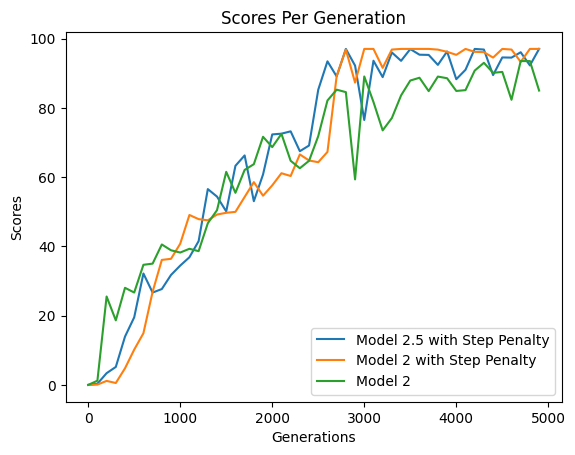

In [50]:
import matplotlib.pyplot as plt
import numpy as np

xs = np.arange(0, 4901, 100)


plt.plot(xs, gen_scores,label = 'Model 2.5 with Step Penalty')
plt.plot(xs, gen_scores2, label = 'Model 2 with Step Penalty')
plt.plot(xs, gen_scores3, label='Model 2')
plt.title("Scores Per Generation")
plt.xlabel("Generations")
plt.ylabel("Scores")
plt.legend()
plt.show()

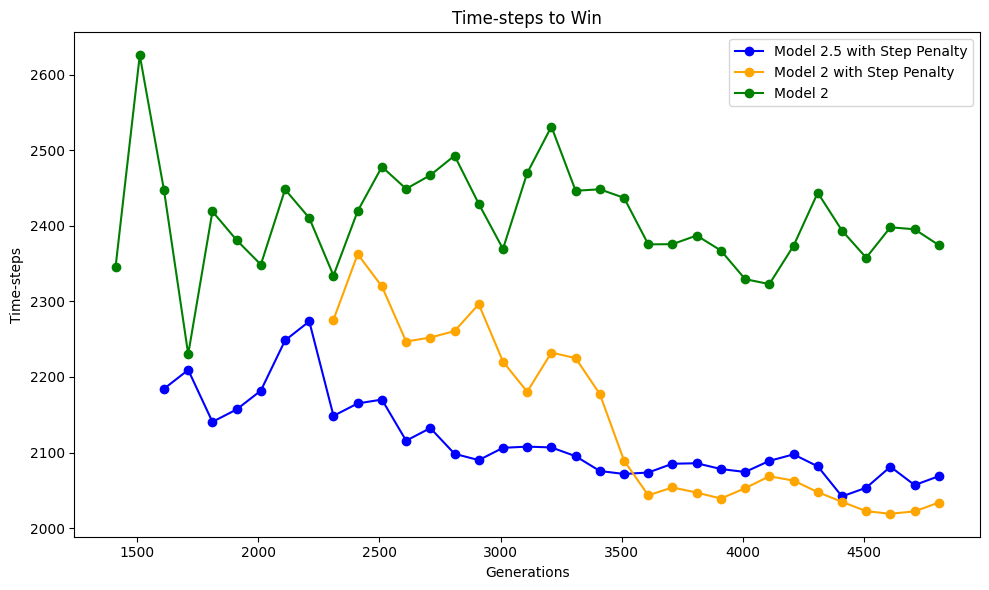

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def add_trendline(x,y, color):
    slope, intercept,_,_,_ = linregress(x,y)
    plt.plot(x,slope*x + intercept, color = color, linestyle = '-', linewidth = 2)
xs = np.arange(10, 4901, 100)
window_size = 2
y_smooth = np.convolve(gen_times, np.ones(window_size)/window_size, mode='valid')
y_smooth2 = np.convolve(gen_times2, np.ones(window_size)/window_size, mode='valid')
y_smooth3 = np.convolve(gen_times3, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize = (10, 6))
plt.plot(xs,y_smooth, color = 'blue', linestyle = '-', marker = 'o',label = 'Model 2.5 with Step Penalty')
plt.plot(xs,y_smooth2, color = 'orange', linestyle = '-', marker = 'o', label = 'Model 2 with Step Penalty')
plt.plot(xs,y_smooth3, color = 'green', linestyle = '-', marker = 'o', label = 'Model 2')

# plt.scatter(xs, gen_times, label = 'Fast Size')
# plt.scatter(xs, gen_times2, label = 'Fast')
# plt.scatter(xs, gen_times3, label = 'Model 2')
# add_trendline(xs, gen_times, 'green')
plt.title("Time-steps to Win")
plt.xlabel("Generations")
plt.ylabel("Time-steps")
plt.legend()
plt.tight_layout()

plt.show()

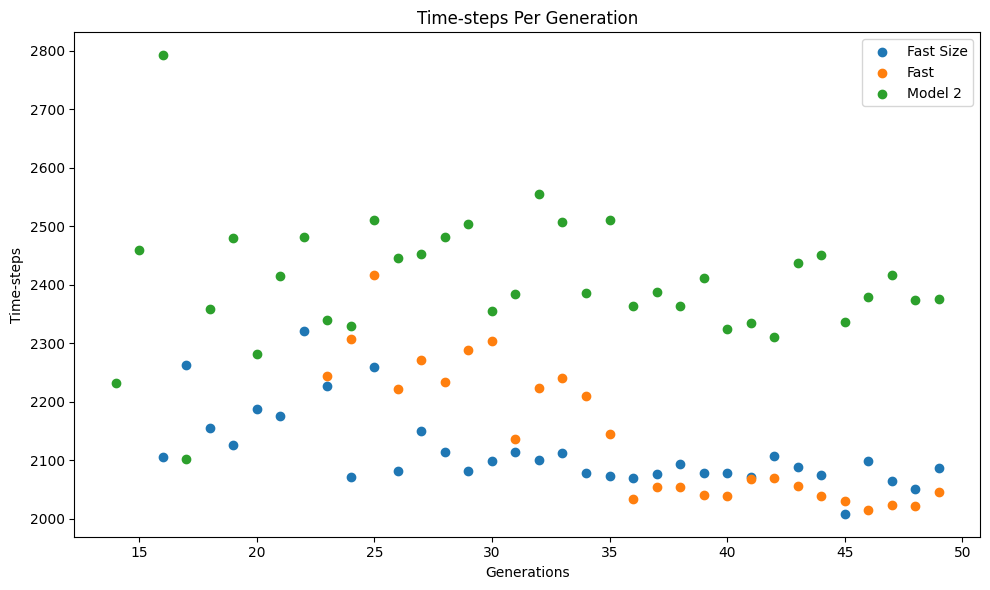

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def add_trendline(x,y, color):
    slope, intercept,_,_,_ = linregress(x,y)
    plt.plot(x,slope*x + intercept, color = color, linestyle = '-', linewidth = 2)
xs = np.arange(0, 4901, 100)
x = np.arange(0,50)
window_size = 5
# y_smooth = np.convolve(gen_times, np.ones(window_size)/window_size, mode='valid')
# y_smooth2 = np.convolve(gen_times2, np.ones(window_size)/window_size, mode='valid')
# y_smooth3 = np.convolve(gen_times3, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize = (10, 6))
# plt.plot(y_smooth, color = 'blue', linestyle = '-', marker = 'o')
# plt.plot(y_smooth2, color = 'orange', linestyle = '-', marker = 'o')
# plt.plot(y_smooth3, color = 'green', linestyle = '-', marker = 'o')

plt.scatter(x, gen_times, label = 'Fast Size')
plt.scatter(x, gen_times2, label = 'Fast')
plt.scatter(x, gen_times3, label = 'Model 2')
# add_trendline(xs, gen/_times, 'green')
plt.title("Time-steps Per Generation")
plt.xlabel("Generations")
plt.ylabel("Time-steps")
plt.legend()
plt.tight_layout()

plt.show()